In [122]:
# Standard libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.gridspec import GridSpec
pd.set_option('display.max_columns', 100)
import plotly.offline as py
import plotly.express as px
import plotly.graph_objs as go
import json
import requests
import folium


from datetime import datetime as dt
import calendar
import warnings
warnings.filterwarnings("ignore")

from wordcloud import WordCloud
from collections import Counter
from PIL import Image

# DataPrep
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb

In [91]:
import time
start = time.time()

cust_data = pd.read_csv("C:/Users/mncedisi.mncwabe/Videos/Practice/ML Challenges/Segmentation/archive/olist_customers_dataset.csv")
geo_data = pd.read_csv("C:/Users/mncedisi.mncwabe/Videos/Practice/ML Challenges/Segmentation/archive/olist_geolocation_dataset.csv")
item_data = pd.read_csv("C:/Users/mncedisi.mncwabe/Videos/Practice/ML Challenges/Segmentation/archive/olist_order_items_dataset.csv")
pay_data = pd.read_csv("C:/Users/mncedisi.mncwabe/Videos/Practice/ML Challenges/Segmentation/archive/olist_order_payments_dataset.csv")
rev_data = pd.read_csv("C:/Users/mncedisi.mncwabe/Videos/Practice/ML Challenges/Segmentation/archive/olist_order_reviews_dataset.csv")
orders_data = pd.read_csv("C:/Users/mncedisi.mncwabe/Videos/Practice/ML Challenges/Segmentation/archive/olist_orders_dataset.csv")
prod_data = pd.read_csv("C:/Users/mncedisi.mncwabe/Videos/Practice/ML Challenges/Segmentation/archive/olist_products_dataset.csv")
sel_data = pd.read_csv("C:/Users/mncedisi.mncwabe/Videos/Practice/ML Challenges/Segmentation/archive/olist_sellers_dataset.csv")

end = time.time()
print("reading time: ",(end-start),"sec")

reading time:  2.1572136878967285 sec


In [92]:
rev_data.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


## Data Preprocessing

In [93]:
# checking number of columns , column_names and no_of_rows
datasets = [cust_data,geo_data,item_data,pay_data,rev_data,orders_data,prod_data,sel_data]
titles = ["customers","geolocations","items", "payments","reviews" ,"orders", "products","sellers"]

info_df = pd.DataFrame({},)
info_df["datasets"] = titles

info_df['no_of_columns']= [len(df.columns) for df in datasets ]
info_df['column_names']= [', '.join(list(df.columns)) for df in datasets] 
info_df['no_of_rows'] = [len(df) for df in datasets]

info_df.style.background_gradient(cmap='Greys')

,datasets,no_of_columns,column_names,no_of_rows
0,customers,5,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",99441
1,geolocations,5,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state",1000163
2,items,7,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",112650
3,payments,5,"order_id, payment_sequential, payment_type, payment_installments, payment_value",103886
4,reviews,7,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",100000
5,orders,8,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",99441
6,products,9,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",32951
7,sellers,4,"seller_id, seller_zip_code_prefix, seller_city, seller_state",3095


In [94]:
#checking dtypes

datasets = [cust_data,geo_data,item_data,pay_data,rev_data,orders_data,prod_data,sel_data]
titles = ["customers","geolocations","items", "payments","reviews" ,"orders", "products","sellers"]

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
new_df = pd.DataFrame({},)
new_df['dataset']= titles

new_df['numeric_features'] = [len((df.select_dtypes(include=numerics)).columns) for df in datasets]
new_df['num_features_name'] = [', '.join(list((df.select_dtypes(include=numerics)).columns)) for df in datasets]
new_df['object_features'] = [len((df.select_dtypes(include='object')).columns) for df in datasets]
new_df['objt_features_name'] = [', '.join(list((df.select_dtypes(include='object')).columns)) for df in datasets]
new_df['bool_features'] = [len((df.select_dtypes(include='bool')).columns) for df in datasets]
new_df.style.background_gradient(cmap='Greys')

,dataset,numeric_features,num_features_name,object_features,objt_features_name,bool_features
0,customers,1,customer_zip_code_prefix,4,"customer_id, customer_unique_id, customer_city, customer_state",0
1,geolocations,3,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng",2,"geolocation_city, geolocation_state",0
2,items,3,"order_item_id, price, freight_value",4,"order_id, product_id, seller_id, shipping_limit_date",0
3,payments,3,"payment_sequential, payment_installments, payment_value",2,"order_id, payment_type",0
4,reviews,1,review_score,6,"review_id, order_id, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",0
5,orders,0,,8,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",0
6,products,7,"product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",2,"product_id, product_category_name",0
7,sellers,1,seller_zip_code_prefix,3,"seller_id, seller_city, seller_state",0


In [95]:
#checking no of null values

datasets = [cust_data,geo_data,item_data,pay_data,rev_data,orders_data,prod_data,sel_data]
titles = ["customers","geolocations","items", "payments","reviews" ,"orders", "products","sellers"]

info_df_n = pd.DataFrame({},)

info_df_n['dataset']= titles

#creating column of name of columns in the dataset 
info_df_n['cols'] = [', '.join([col for col, null in df.isnull().sum().items() ]) for df in datasets]

#creating total number of columns in the dataset 
info_df_n['cols_no']= [df.shape[1] for df in datasets]

#counting total null values
info_df_n['null_no']= [df.isnull().sum().sum() for df in datasets]

#creating total number of columns in the dataset with null-values 
info_df_n['null_cols_no']= [len([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]
#creating column of name of columns in the dataset with null-values 
info_df_n['null_cols'] = [', '.join([col for col, null in df.isnull().sum().items() if null > 0]) for df in datasets]


info_df_n.style.background_gradient(cmap='Greys')

,dataset,cols,cols_no,null_no,null_cols_no,null_cols
0,customers,"customer_id, customer_unique_id, customer_zip_code_prefix, customer_city, customer_state",5,0,0,
1,geolocations,"geolocation_zip_code_prefix, geolocation_lat, geolocation_lng, geolocation_city, geolocation_state",5,0,0,
2,items,"order_id, order_item_id, product_id, seller_id, shipping_limit_date, price, freight_value",7,0,0,
3,payments,"order_id, payment_sequential, payment_type, payment_installments, payment_value",5,0,0,
4,reviews,"review_id, order_id, review_score, review_comment_title, review_comment_message, review_creation_date, review_answer_timestamp",7,146532,2,"review_comment_title, review_comment_message"
5,orders,"order_id, customer_id, order_status, order_purchase_timestamp, order_approved_at, order_delivered_carrier_date, order_delivered_customer_date, order_estimated_delivery_date",8,4908,3,"order_approved_at, order_delivered_carrier_date, order_delivered_customer_date"
6,products,"product_id, product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm",9,2448,8,"product_category_name, product_name_lenght, product_description_lenght, product_photos_qty, product_weight_g, product_length_cm, product_height_cm, product_width_cm"
7,sellers,"seller_id, seller_zip_code_prefix, seller_city, seller_state",4,0,0,


In [96]:
# merge datasets

rev_new = rev_data.drop(['review_comment_title','review_creation_date','review_id','review_answer_timestamp'],axis=1)

data = pd.merge(orders_data,pay_data, on = "order_id")
data = data.merge(cust_data, on = "customer_id" )
data = data.merge(item_data, on="order_id")
data = data.merge(prod_data, on="product_id")
data = data.merge(rev_new, on="order_id")
data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,review_score,review_comment_message
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,4,"Não testei o produto ainda, mas ele veio corre..."
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,3,voucher,1,2.00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,4,"Não testei o produto ainda, mas ele veio corre..."
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2,voucher,1,18.59,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,4,"Não testei o produto ainda, mas ele veio corre..."
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1,credit_card,3,37.77,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,4,Deveriam embalar melhor o produto. A caixa vei...
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1,credit_card,1,37.77,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,5,"Só achei ela pequena pra seis xícaras ,mais é ..."


In [34]:
data.shape

(118315, 32)

In [35]:
data.isnull().sum()/len(data)*100

order_id                          0.000000
customer_id                       0.000000
order_status                      0.000000
order_purchase_timestamp          0.000000
order_approved_at                 0.012678
order_delivered_carrier_date      1.059883
order_delivered_customer_date     2.187381
order_estimated_delivery_date     0.000000
payment_sequential                0.000000
payment_type                      0.000000
payment_installments              0.000000
payment_value                     0.000000
customer_unique_id                0.000000
customer_zip_code_prefix          0.000000
customer_city                     0.000000
customer_state                    0.000000
order_item_id                     0.000000
product_id                        0.000000
seller_id                         0.000000
shipping_limit_date               0.000000
price                             0.000000
freight_value                     0.000000
product_category_name             1.444449
product_nam

In [97]:
data = data.drop('review_comment_message',axis=1)

In [98]:
data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,4
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,3,voucher,1,2.00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,4
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2,voucher,1,18.59,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,4
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1,credit_card,3,37.77,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,4
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1,credit_card,1,37.77,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,5


In [99]:
#Handling missing values
# Timestamps containg missing values are order_approved_at, order_delivered_carrier_date, order_delivered_customer_date.
#null-values in order_approved_at can be replaced by order_purchase_timestamp and null-values 
# in order_delivered_customer_date can be replaced by order_estimated_delivery_date
#we can drop the column order_delivered_carrier_date.

index = (data[data['order_delivered_customer_date'].isnull() == True].index.values)

data["order_approved_at"].fillna(data["order_purchase_timestamp"], inplace=True)
data["order_delivered_customer_date"].fillna(data["order_estimated_delivery_date"], inplace=True)

#dropping order delivery carrier date
data.drop(labels='order_delivered_carrier_date',axis=1,inplace=True)

In [100]:
#checking the replaced values
data.order_estimated_delivery_date[index[0]]

'2018-03-14 00:00:00'

In [101]:
data.order_delivered_customer_date[index[0]]

'2018-03-14 00:00:00'

In [102]:
#Handling missing values for numeric variables
data['product_weight_g'].fillna(data['product_weight_g'].median(),inplace=True)
data['product_length_cm'].fillna(data['product_length_cm'].median(),inplace=True)
data['product_height_cm'].fillna(data['product_height_cm'].median(),inplace=True)
data['product_width_cm'].fillna(data['product_width_cm'].median(),inplace=True)

data['product_category_name'].fillna(data['product_category_name'].mode(),inplace=True)
data['product_name_lenght'].fillna(data['product_name_lenght'].median(),inplace=True)
data['product_description_lenght'].fillna(data['product_description_lenght'].median(),inplace=True)
data['product_photos_qty'].fillna(data['product_photos_qty'].median(),inplace=True)

### Data Deduplication - elimination of duplicate or redundant information

In [103]:
#Deduplication of entries
data = data.drop_duplicates(subset={'order_id','customer_id','order_purchase_timestamp','order_delivered_customer_date'}, 
                            keep='first', inplace=False)
data = data.reindex()
data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,4
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-18 14:44:43,2017-08-28 00:00:00,1,credit_card,3,37.77,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,4
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-07 18:30:01,2017-08-15 00:00:00,1,credit_card,1,37.77,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,5
5,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-11-07 18:04:59,2017-11-13 00:00:00,1,boleto,1,44.09,e781fdcc107d13d865fc7698711cc572,88032,florianopolis,SC,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-31 02:14:11,29.99,14.10,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,3
6,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13 00:00:00,1,boleto,1,141.46,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.70,22.76,perfumaria,29.0,178.0,1.0,400.0,19.0,13.0,19.0,4


In [53]:
data.shape

(98665, 30)

## Data Analysis

In [104]:
# convert the time stamps from object to datetime
 
data[['order_purchase_timestamp','order_approved_at','order_delivered_customer_date',
      'order_estimated_delivery_date',]]=data[['order_purchase_timestamp',
       'order_approved_at','order_delivered_customer_date','order_estimated_delivery_date']].apply(pd.to_datetime)

In [105]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98665 entries, 0 to 118314
Data columns (total 30 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       98665 non-null  object        
 1   customer_id                    98665 non-null  object        
 2   order_status                   98665 non-null  object        
 3   order_purchase_timestamp       98665 non-null  datetime64[ns]
 4   order_approved_at              98665 non-null  datetime64[ns]
 5   order_delivered_customer_date  98665 non-null  datetime64[ns]
 6   order_estimated_delivery_date  98665 non-null  datetime64[ns]
 7   payment_sequential             98665 non-null  int64         
 8   payment_type                   98665 non-null  object        
 9   payment_installments           98665 non-null  int64         
 10  payment_value                  98665 non-null  float64       
 11  customer_uniqu

In [56]:
data.describe()

,payment_sequential,payment_installments,payment_value,customer_zip_code_prefix,order_item_id,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,review_score
count,98665.000000,98665.000000,98665.000000,98665.000000,98665.000000,98665.000000,98665.000000,98665.000000,98665.000000,98665.000000,98665.000000,98665.000000,98665.000000,98665.000000,98665.000000
mean,1.022845,2.917083,157.959931,35157.180185,1.015608,125.896084,20.185955,48.894978,791.175979,2.232919,2102.539553,30.098900,16.485897,23.022977,4.089829
std,0.250446,2.709189,218.029937,29798.842131,0.143791,191.169106,15.913924,9.929520,650.386532,1.740242,3763.959507,16.122346,13.321972,11.738519,1.343595
min,1.000000,0.000000,0.010000,1003.000000,1.000000,0.850000,0.000000,5.000000,4.000000,1.000000,0.000000,7.000000,2.000000,6.000000,1.000000
25%,1.000000,1.000000,60.010000,11360.000000,1.000000,41.800000,13.270000,43.000000,352.000000,1.000000,300.000000,18.000000,8.000000,15.000000,4.000000
50%,1.000000,2.000000,103.330000,24425.000000,1.000000,79.000000,16.350000,52.000000,600.000000,1.000000,700.000000,25.000000,13.000000,20.000000,5.000000
75%,1.000000,4.000000,175.080000,58995.000000,1.000000,139.900000,21.220000,57.000000,987.000000,3.000000,1800.000000,38.000000,20.000000,30.000000,5.000000
max,27.000000,24.000000,13664.080000,99990.000000,7.000000,6735.000000,409.680000,76.000000,3992.000000,20.000000,40425.000000,105.000000,105.000000,118.000000,5.000000


In [ ]:
# We can observe the statistics like percentile values , mean and standard deviation values, count , 
# min and max of the numerical featues.For payment_value, the maximum payment value of an order is 13664 Brazilian real.

# For the price and freight value of an order. The maximum price of an order is 6735 while max 
# freight is around 410 Brazilian real. The average price of an order is around 125 Brazilian real 
# and frieght value is around 20 Brazilian real. The order with minimum price of 0.85 Brazilian real have been made.
# The average review score is 4 which is a good score

# Similarly, we can observe the other features further we will see the distribution of 
# these features and see how they are helping in classifying the class labels and find other insights

In [57]:
# checking the target variable i.e review score 
data.review_score.value_counts()

5    57039
4    19065
1    11232
3     8178
2     3151
Name: review_score, dtype: int64

In [106]:
# let's convert it to binary i.e 0 for scores less than 3 and 1 for scores above or equal to 3

def partition(x):
    if x < 3:
        return 0
    return 1
data['review_score'] = data['review_score'].map(lambda cw : partition(cw))

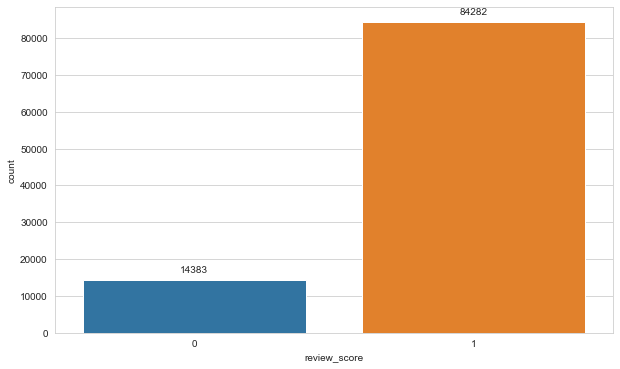

In [108]:
plt.figure(figsize = (10,6))
plot = sns.countplot(x ='review_score',data=data)
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [ ]:
# only 14.5% reviews are negative(0, that is they are less than 3). And 85% positive reviews


Total Positive Reviews : 84282 , ( 85.42238889170424 %)
Total Negative Reviews : 14383 , ( 14.577611108295748 %)




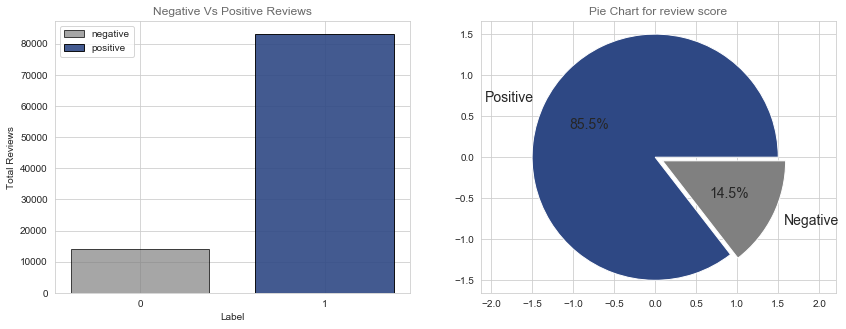

In [109]:
#counting the review score with 1 and 0
y_value_counts = data.review_score.value_counts()

#calculating the percentage of each review type
print("Total Positive Reviews :", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Total Negative Reviews :", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print('\n')

#plotting bar-plot and pie chart
%matplotlib inline
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.ylabel('Total Reviews')
plt.xlabel('Label')
plt.title('Negative Vs Positive Reviews',color='dimgrey')
plt.xticks([10,10.20],['0','1'])
#creating bar plots
plt.bar(10,14112, color = 'grey', width = 0.15,alpha=0.7,label='negative',edgecolor='black')
plt.bar(10.20,83143,color = '#2e4884', width = 0.15,alpha=0.9,label='positive',edgecolor='black')
plt.legend()

plt.subplot(1,2,2)
labels = ['Positive','Negative']
sizes = [83143,14112]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')
color={'#2e4884','grey'}
plt.pie(sizes,explode=explode ,colors=color,labels=labels, autopct='%1.1f%%',shadow=False, 
                   startangle=0,radius=1.5,labeldistance=1.1,textprops={'fontsize': 14},frame=True, )
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Pie Chart for review score',color='dimgrey')
plt.show()

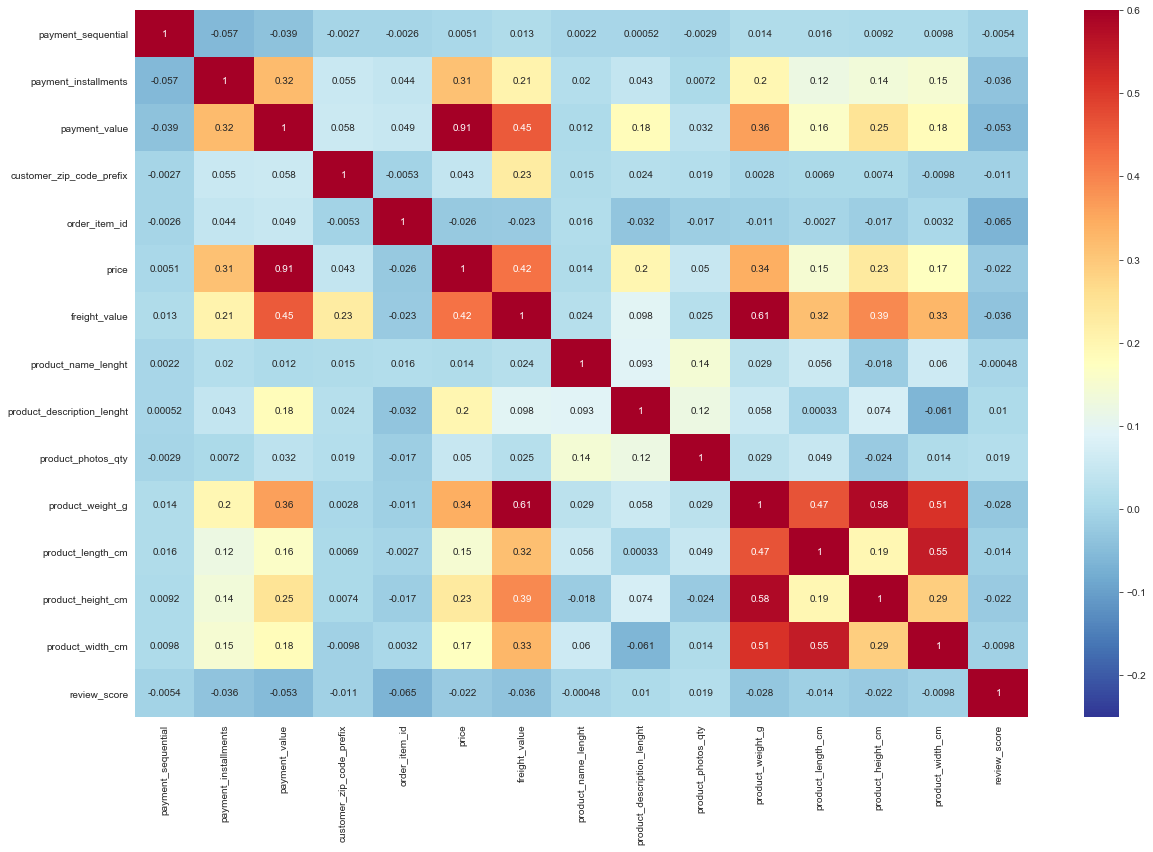

In [110]:
# correlation

plt.figure(figsize = (20,13))
sns.heatmap(data.corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6);

In [ ]:
# From the correlation heatmap, it can be seen that Price and Payment value are strongly positively correlated
# Same can be seen between Freight value and Product weight
# also with (product_length_cm and product_width_cm), (product_height_cm and product_weight_g)
# we will drop one of the highly correlated variables from each pair so that the model performs better

In [111]:
data = data.drop(['product_width_cm','product_height_cm','price'], axis=1)

In [112]:
#finding corr- values of the features with review_score

corr_matrix = data.corr()
corr_matrix["review_score"].sort_values(ascending=False)

review_score                  1.000000
product_photos_qty            0.019146
product_description_lenght    0.010485
product_name_lenght          -0.000479
payment_sequential           -0.005438
customer_zip_code_prefix     -0.010913
product_length_cm            -0.014137
product_weight_g             -0.027561
freight_value                -0.035786
payment_installments         -0.036285
payment_value                -0.053410
order_item_id                -0.065218
Name: review_score, dtype: float64

## Univariate Analysis

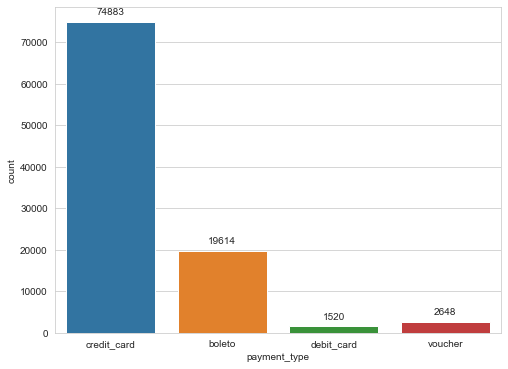

In [113]:
plt.figure(figsize = (8,6))
plot = sns.countplot(x ='payment_type',data=data)
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [ ]:
# From the above plot we can observe that most of the 
# orders are paid using credit card (75% users) and the second most used payment method is Boleto (19% users/customers)

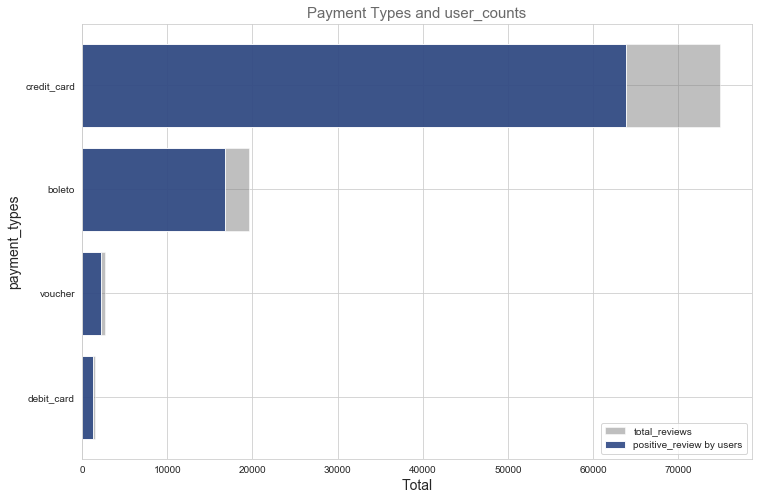

In [114]:
#Let us see how this categorical feature (payment type) is related with our target variable
temp = pd.DataFrame(data.groupby('payment_type')['review_score'].agg(lambda x: x.eq(1).sum())).reset_index()

# Pandas dataframe grouby count
temp['total'] = list(pd.DataFrame(data.groupby('payment_type')['review_score'].agg([('total','count'),('Avg','mean')]))['total'])
temp['Avg']   = list(pd.DataFrame(data.groupby('payment_type')['review_score'].agg([('total','count'),('Avg','mean')]))['Avg'])
#sorting dataframe
temp = temp.sort_values(by=['total'], ascending=True)

plt.figure(figsize=(12,8))
p1=plt.barh(temp.payment_type, temp.total,color='grey',alpha=0.5)
p2=plt.barh(temp.payment_type, temp.review_score,color='#2e4884',alpha=0.9)
plt.title('Payment Types and user_counts',fontsize=15,color='dimgrey')
plt.ylabel('payment_types',fontsize=14)
plt.xlabel('Total',fontsize=14)
plt.legend((p1[0], p2[0]), ('total_reviews', 'positive_review by users'))

plt.show()

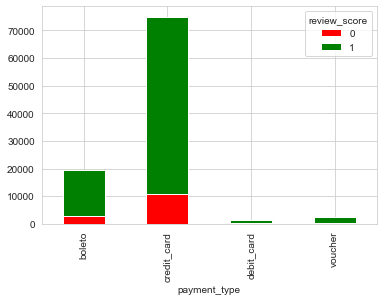

In [79]:
pay_plot = pd.crosstab(data["payment_type"],data['review_score'])
pay_plot.plot(kind = 'bar',stacked = True,color=['red','green']);

In [ ]:
# We can observe from the above stacked plot that most of the customers who used credit card have given positive reviews.
# Also, for the boleto, voucher and the debit card user it is the same.
# From this we can conclude that this can be our important categorical feature for the problem.

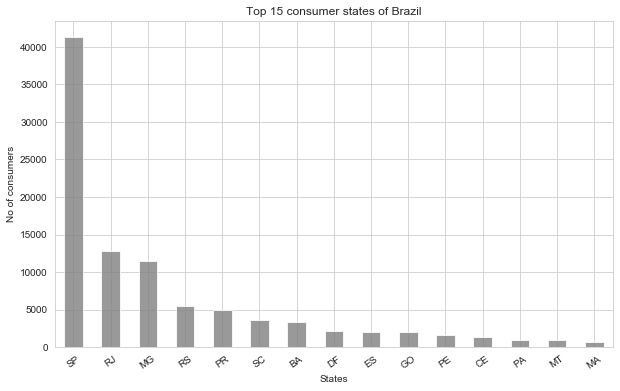

In [80]:
# State with the consumers count
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
ax = data.customer_state.value_counts().sort_values(ascending=False)[0:15].plot(kind='bar', color = 'grey', alpha=0.8)
ax.set_title("Top 15 consumer states of Brazil")
ax.set_xlabel("States")
plt.xticks(rotation=35)
ax.set_ylabel("No of consumers")
plt.show()

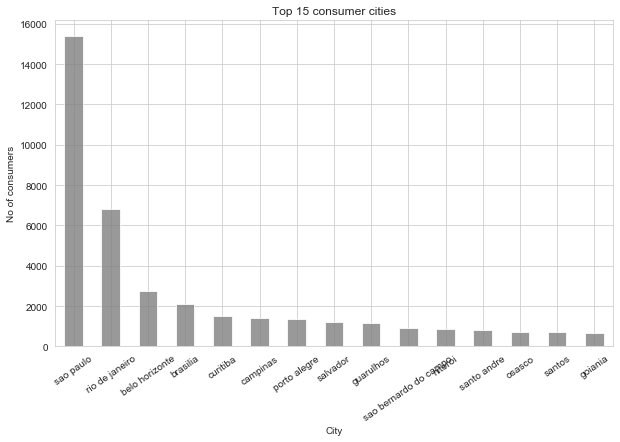

In [82]:
# State with the consumers count
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
ax = data.customer_city.value_counts().sort_values(ascending=False)[0:15].plot(kind='bar', color = 'grey', alpha=0.8)
ax.set_title("Top 15 consumer cities")
ax.set_xlabel("City")
plt.xticks(rotation=35)
ax.set_ylabel("No of consumers")
plt.show()

In [ ]:
# 42% of total consumers are from the SP(São Paulo), 12.9 % are from RJ(Rio de Janeiro)
# and 11.7 % are from MG(Minas Gerais) which means most of consumers are from these states.
# Now, Let us see what type of reviews are given from the consumer of these states

<Figure size 1080x576 with 0 Axes>

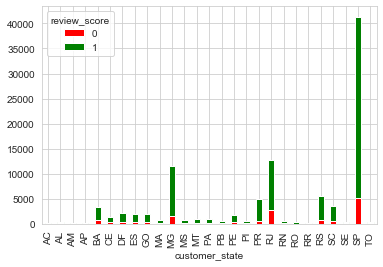

In [84]:
plt.figure(figsize=(15,8))
pay_plot = pd.crosstab(data["customer_state"],data['review_score'])
pay_plot.plot(kind = 'bar',stacked = True,color=['red','green']);

In [ ]:
# From the avove stack plot of reviews per state we can conclude that most of consumers
# from each state has given positive reviews.In SP state from the total reviews of 40800 , 
# 35791 reviews are positive reviews and for RJ state 9968 reviews are positive from the total reviews 12569.
# The consumer_state can be our important feature for the problem

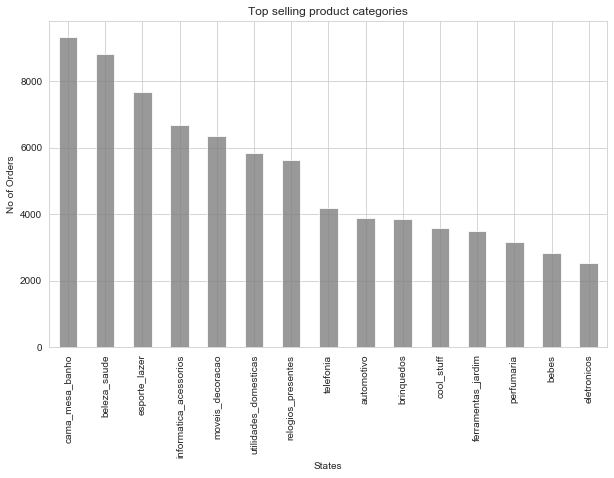

In [89]:
plt.figure(figsize=(10,6))
sns.set_style("whitegrid")
ax = data.product_category_name.value_counts().sort_values(ascending=False)[0:15].plot(kind='bar', color = 'grey', alpha=0.8)
ax.set_title("Top selling product categories")
ax.set_xlabel("States")
plt.xticks(rotation=90)
ax.set_ylabel("No of Orders")
plt.show()

In [ ]:
# From the plot above we can conclude that most ordered products is 
# from bed_bath_table category ,health beauty and sports_leisure between 2016 and 2018.
# The least ordered products are from security_and_services

In [115]:
data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,1
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-18 14:44:43,2017-08-28,1,credit_card,3,37.77,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,1
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-07 18:30:01,2017-08-15,1,credit_card,1,37.77,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,1
5,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-11-07 18:04:59,2017-11-13,1,boleto,1,44.09,e781fdcc107d13d865fc7698711cc572,88032,florianopolis,SC,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-31 02:14:11,14.10,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,1
6,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13,1,boleto,1,141.46,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,22.76,perfumaria,29.0,178.0,1.0,400.0,19.0,1


<Figure size 1080x576 with 0 Axes>

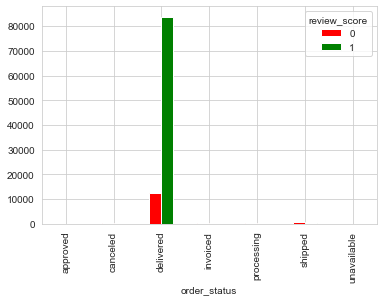

In [121]:
plt.figure(figsize=(15,8))
status_plot = pd.crosstab(data["order_status"],data['review_score'])
status_plot.plot(kind = 'bar',stacked = False,color=['red','green']);

In [ ]:
# The second plot shows that for the order_status delivered most 
# of the orders are with positive reviews i.e 85% and only 12.8% are negative reviews.

Text(0.5, 1.0, 'Number of orders per customer')

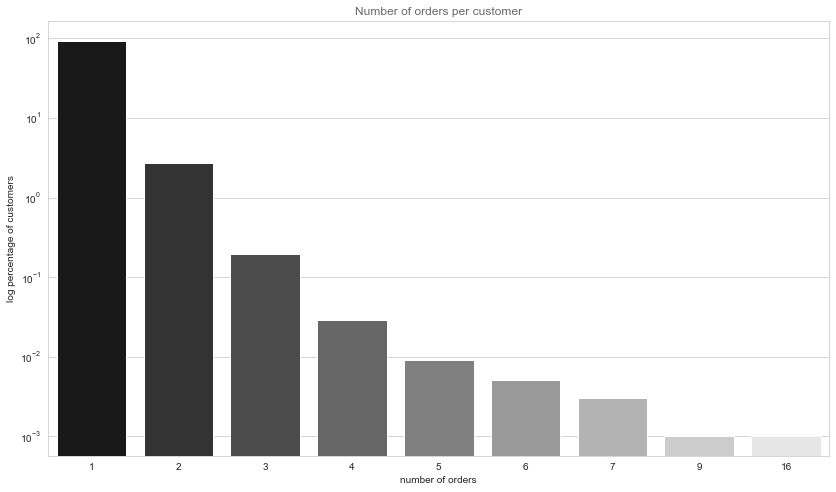

In [118]:
# plotting frequency orders vs  the number of consumers 
plt.figure(figsize=(14,8))

#counting the consumers and converting it into percentage to visualize the distribution properly
num_orders=data['customer_unique_id'].value_counts().value_counts()/data.shape[0]*100
num_orders=num_orders.reset_index()
#renaming the columns
num_orders.rename(columns={'index':'number of orders', 'customer_unique_id':'log percentage of customers'},inplace=True)

#plotting bar plot
sns.barplot(data=num_orders,x='number of orders',y='log percentage of customers',palette='gray')
plt.yscale('log') #log scale
plt.title('Number of orders per customer',color='dimgrey')

In [ ]:
# Most of the consumers placed orders of any products only for once and few consumers 
# are also present who oredred products more than 16 times. 
# From this we can say order frequecy can be used as important feature for the problem.

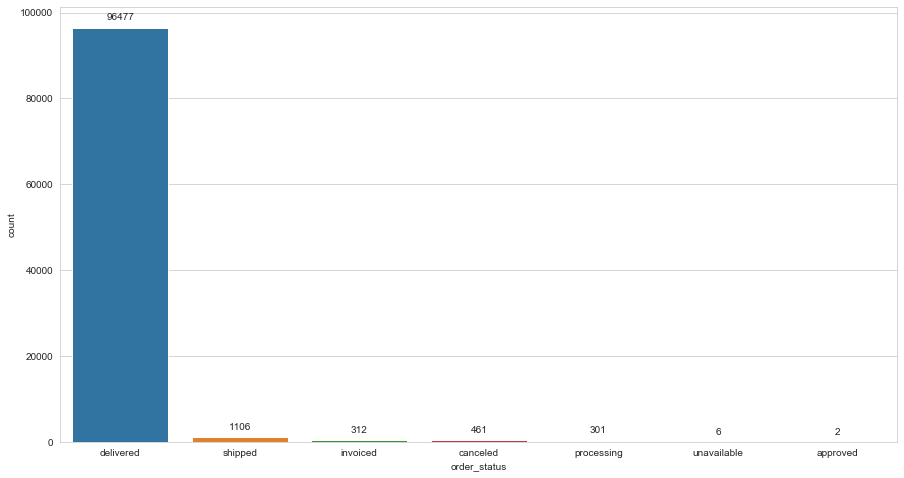

In [120]:
plt.figure(figsize=(15,8))
plot = sns.countplot(x='order_status',data=data)
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x() + p.get_width() / 2., p.get_height()), 
                  ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [ ]:
# most of the orders were delivered
# few orders are still on shipped status and some were invoiced, cancelled or are still being processed

### Univariate analysis for datetime variables

In [126]:
# extract year, month etc from datetime variables
data['Day_of_Week']=data['order_purchase_timestamp'].dt.day_name()
data['Month']=data['order_purchase_timestamp'].dt.month_name()
data['Year']=data['order_purchase_timestamp'].dt.year
data['Hour']=data['order_purchase_timestamp'].dt.hour
data['Day']=data['order_purchase_timestamp'].dt.day
data['Month_yr'] = data['order_purchase_timestamp'].apply(lambda x: x.strftime("%b-%y"))

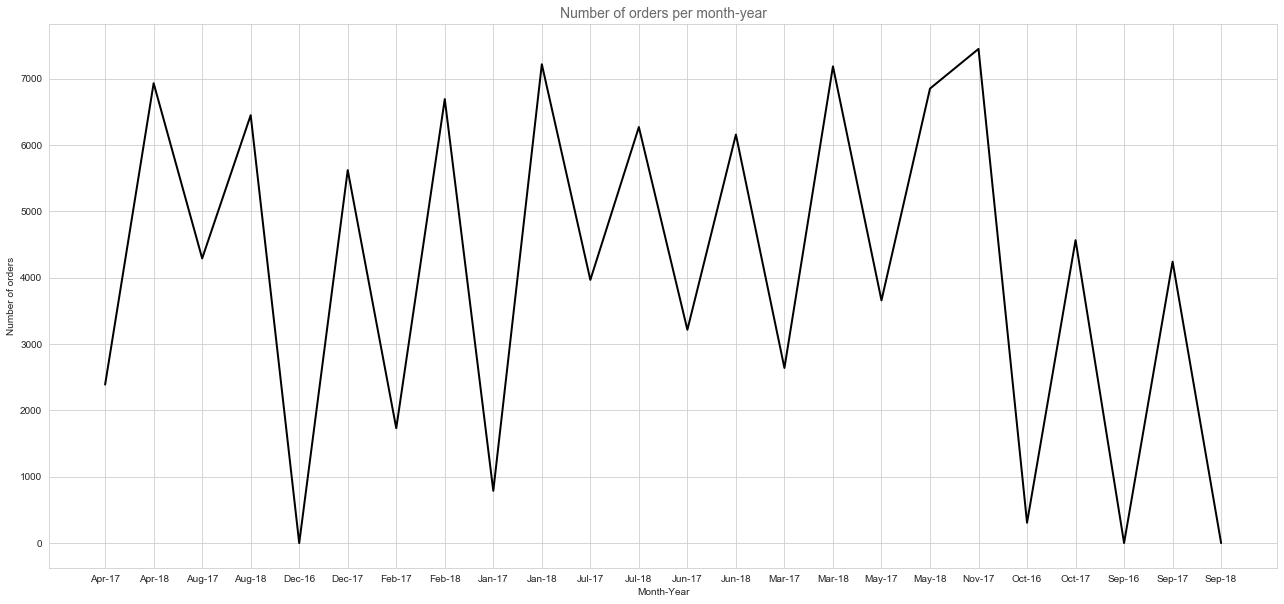

In [138]:
plt.figure(figsize=(22,10))
sns.lineplot(data=data['Month_yr'].value_counts().sort_index(), color='black', linewidth=2)
plt.title('Number of orders per month-year', size=14, color='dimgrey')
plt.ylabel("Number of orders")
plt.xlabel("Month-Year")
plt.show()

In [139]:
data.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_item_id,product_id,seller_id,shipping_limit_date,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,review_score,Day_of_Week,Month,Year,Hour,Day,Month_yr
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,1,credit_card,1,18.12,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,8.72,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,1,Monday,October,2017,10,2,Oct-17
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-18 14:44:43,2017-08-28,1,credit_card,3,37.77,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,1,Tuesday,August,2017,18,15,Aug-17
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-07 18:30:01,2017-08-15,1,credit_card,1,37.77,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,7.78,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,1,Wednesday,August,2017,18,2,Aug-17
5,bfc39df4f36c3693ff3b63fcbea9e90a,53904ddbea91e1e92b2b3f1d09a7af86,delivered,2017-10-23 23:26:46,2017-10-25 02:14:11,2017-11-07 18:04:59,2017-11-13,1,boleto,1,44.09,e781fdcc107d13d865fc7698711cc572,88032,florianopolis,SC,1,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-31 02:14:11,14.10,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,1,Monday,October,2017,23,23,Oct-17
6,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13,1,boleto,1,141.46,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,1,595fac2a385ac33a80bd5114aec74eb8,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,22.76,perfumaria,29.0,178.0,1.0,400.0,19.0,1,Tuesday,July,2018,20,24,Jul-18


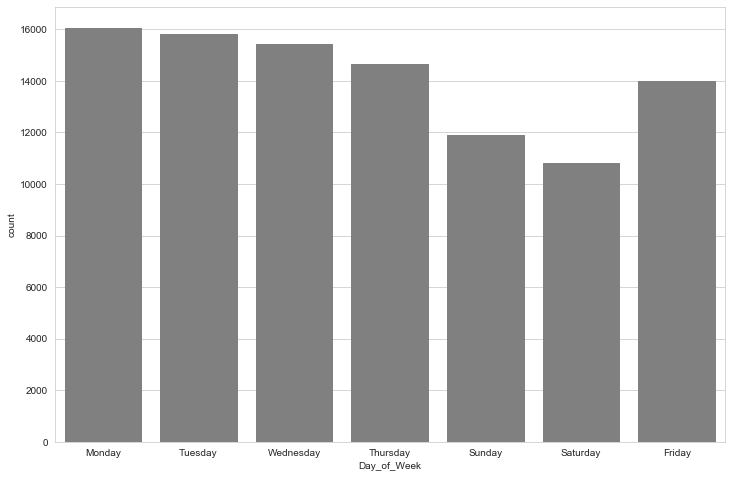

In [140]:
# Most of the orders are placed at the beginning of the week (Monday, Tuesday, Wednesday)
plt.figure(figsize=(12,8))
sns.countplot(x='Day_of_Week',data=data,color='grey',edgecolor='grey')

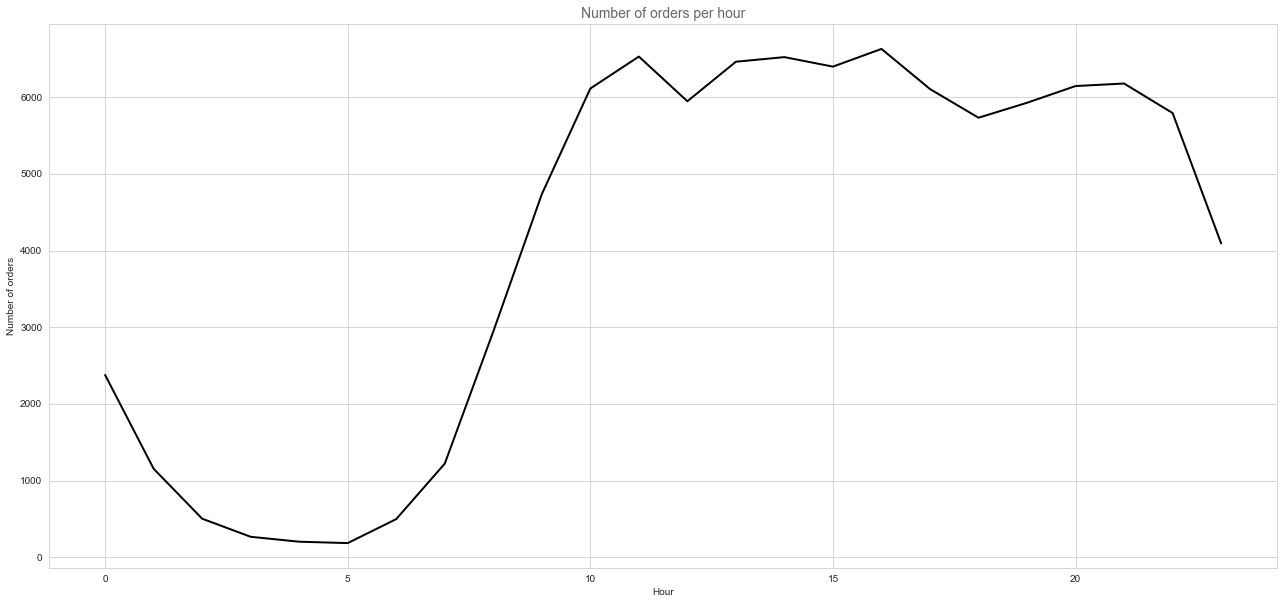

In [141]:
plt.figure(figsize=(22,10))
sns.lineplot(data=data['Hour'].value_counts().sort_index(), color='black', linewidth=2)
plt.title('Number of orders per hour', size=14, color='dimgrey')
plt.ylabel("Number of orders")
plt.xlabel("Hour")
plt.show()

In [ ]:
# we can see the trend in terms of the orders placed through the day.
# Most orders are placed after 10am and they start decreasing towards eveing and night hours

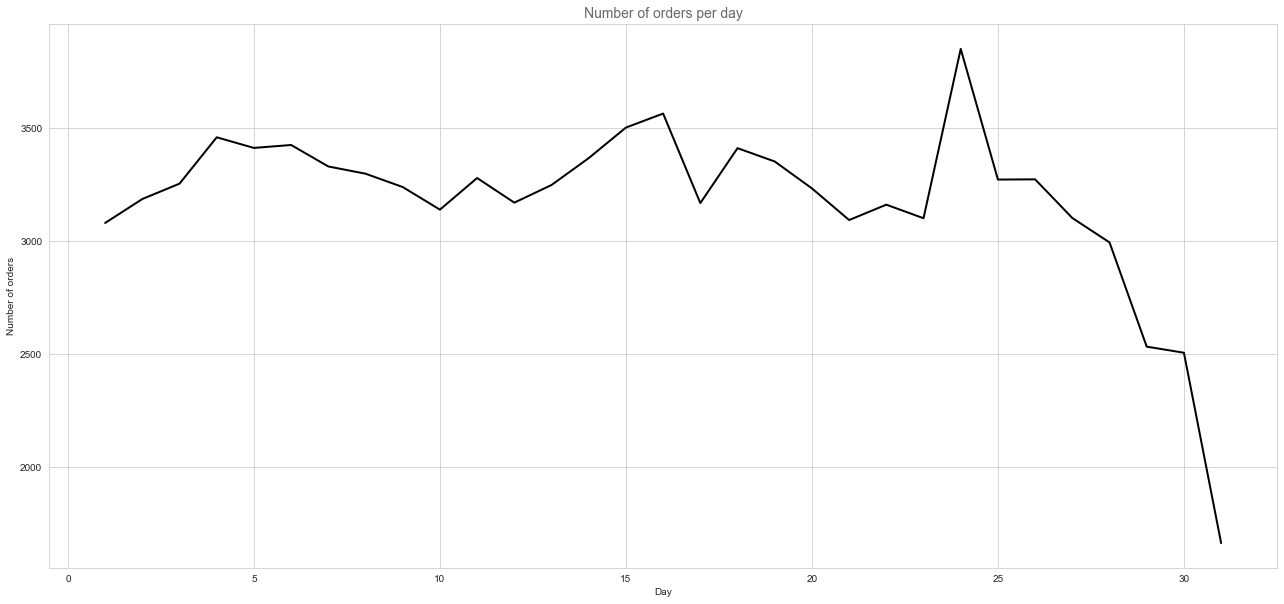

In [142]:
plt.figure(figsize=(22,10))
sns.lineplot(data=data['Day'].value_counts().sort_index(), color='black', linewidth=2)
plt.title('Number of orders per day', size=14, color='dimgrey')
plt.ylabel("Number of orders")
plt.xlabel("Day")
plt.show()

In [ ]:
# Most orders are placed at the begenning of the month and around the 23rd and 24th of the month

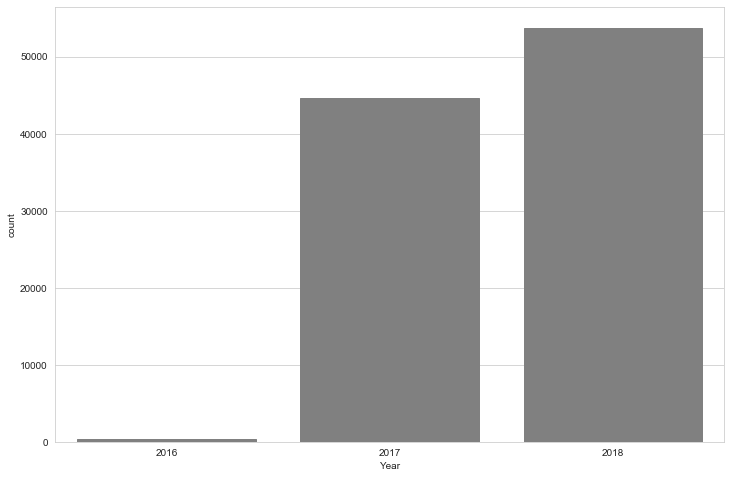

In [143]:
# 2018 had the most number of orders placed
plt.figure(figsize=(12,8))
sns.countplot(x='Year',data=data,color='grey',edgecolor='grey')

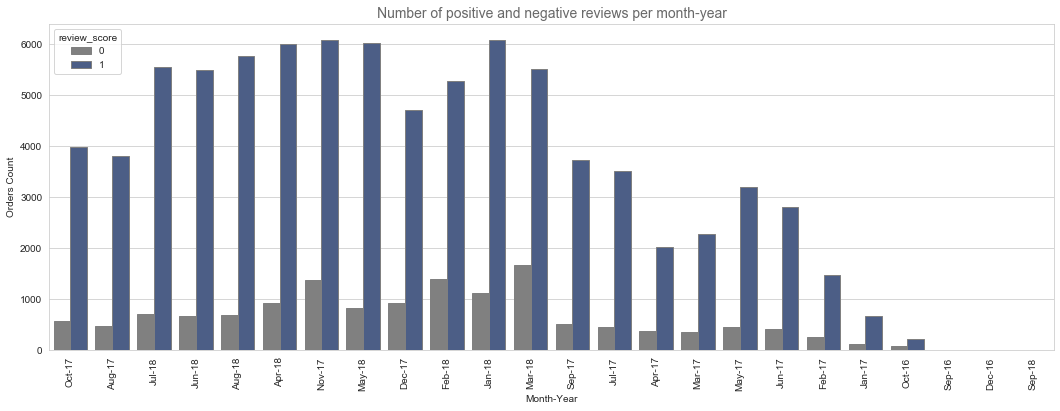

In [145]:
#plotting number of positive and negative reviews per month-year
plt.figure(figsize=(18,6))
g = sns.countplot(x='Month_yr',hue='review_score',data=data,palette=['grey','#425a90'],edgecolor='grey')
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g.set_xlabel('Month-Year')
g.set_ylabel('Orders Count')
plt.title('Number of positive and negative reviews per month-year', size=14, color='dimgrey');

<Figure size 432x288 with 0 Axes>

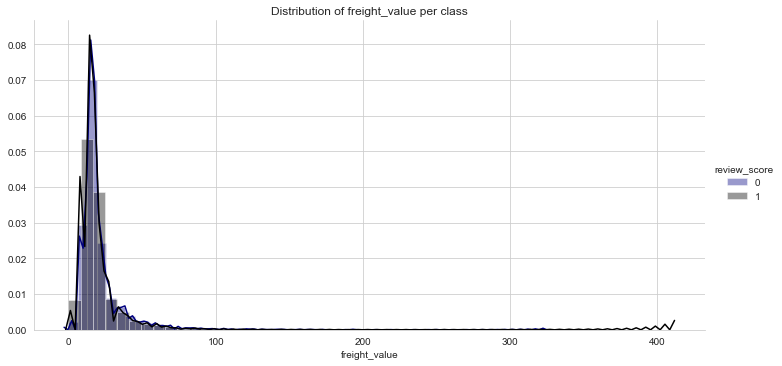

In [146]:
# plotting distributions of freight_value per class
plt.figure()
#sns.set_style("whitegrid")
ax = sns.FacetGrid(data, hue="review_score", height=5,aspect=2.0,palette=['#000080','black'])
ax = ax.map(sns.distplot, "freight_value").add_legend();
plt.title('Distribution of freight_value per class')
plt.show()

In [ ]:
#The above distribution plot shows the distribution of freight_value for both the postive and negative classes. 
#We can observe that there is almost completely overlap of both the distribution for
#positive and negative class which suggests that
#it is not possible to classify them based only on freight_value feature.

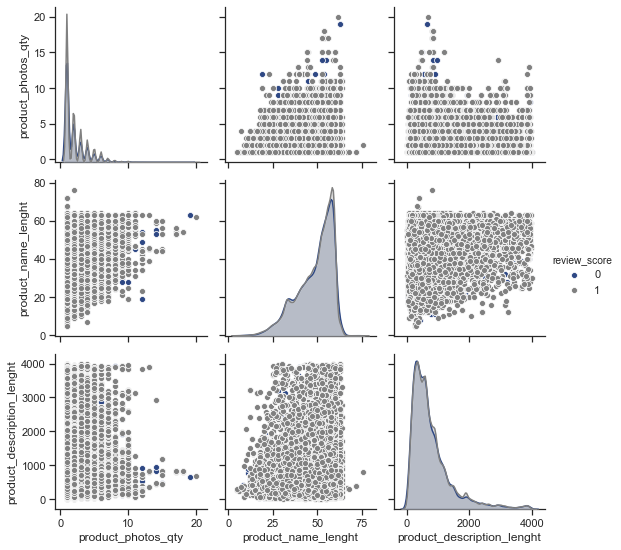

In [147]:
# pair plot
sns.set(style="ticks", color_codes=True)
g = sns.pairplot(data[['product_photos_qty','product_name_lenght','product_description_lenght','review_score']],
                 hue='review_score',palette=['#2e4884','grey'])
g.savefig("pairplot1.png")

In [ ]:
# The pair plot shown above for the features product_photos_qty, product_name_length,product_description_length
# as these have negative correlation values with the review_score column.
# All the scatter plots between the features are completely mixed up not separable on the basis of reviews.
# We can say that none of these features are helpful for the classification.

### RFM Analysis

In [148]:
PRESENT = datetime(2018,9,3)
rfm= data.groupby('customer_unique_id').agg({'order_purchase_timestamp': lambda date: (PRESENT - date.max()).days,
                                        'order_id': lambda num: len(num),
                                        'payment_value': lambda price: price.sum()})
rfm.columns=['recency','frequency','monetary']
rfm['recency'] = rfm['recency'].astype(int)
rfm['frequency'] = rfm['frequency'].astype(int)
rfm['monetary'] = rfm['monetary'].astype(float)

In [150]:
rfm.head()

,recency,frequency,monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19
0000f46a3911fa3c0805444483337064,541,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,325,1,43.62
0004aac84e0df4da2b147fca70cf8255,292,1,196.89


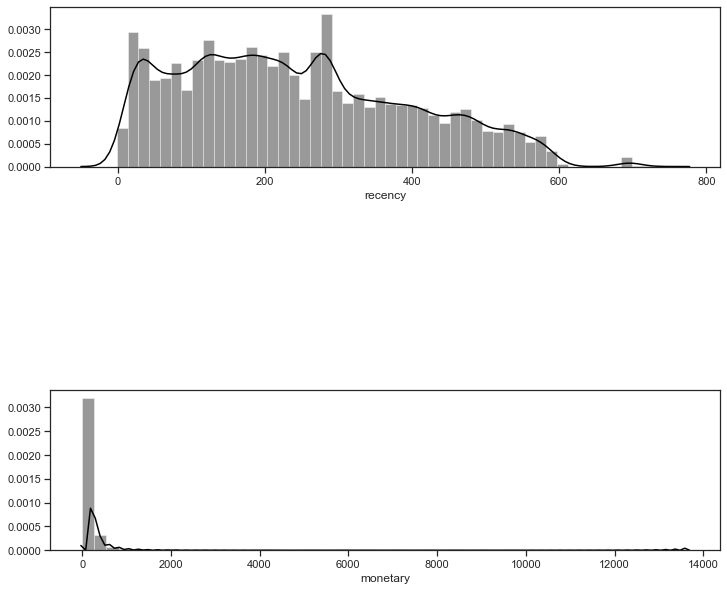

In [155]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(rfm['recency'],color='black')
# Plot distribution of F
#plt.subplot(3, 1, 2); sns.distplot(rfm['frequency'],color='black')
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(rfm['monetary'],color='black')
# Show the plot
plt.show()

In [ ]:
# There are three density plots of recency, frequency and monetary are plotted.
# From the first plot of recency we can observe that most of the users stayed with olist for 
# long duration which is positive thing but order frequency is less.

# from the second plot of frequency most number of transaction or order is less than 5. 
# from the third plot of monetary the maximum amount spend over the given very period is seems to less than 1500 approx.

In [157]:
# Create labels for Recency and Frequency
def partition(x):
    if x < 10:
        return 1
    if 10<=x<=35:
        return 2
    if 35<x<=50:
        return 3
    if 50<x<=75:
        return 4      

rfm['f_quartile']=rfm['frequency'].map(lambda cw : partition(cw) ) 
    
# checking the review score now
rfm.f_quartile.value_counts()
r_labels = range(4, 0, -1);m_labels= range(1,5)

rfm['r_quartile'] = pd.qcut(rfm['recency'], 4, r_labels)
rfm['m_quartile'] = pd.qcut(rfm['monetary'], 4, m_labels)

In [158]:
rfm['RFM_Score'] = rfm.r_quartile.astype(str)+ rfm.f_quartile.astype(str) + rfm.m_quartile.astype(str)
rfm.head()

,recency,frequency,monetary,f_quartile,r_quartile,m_quartile,RFM_Score
customer_unique_id,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,1,4,3,413
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,1,4,1,411
0000f46a3911fa3c0805444483337064,541,1,86.22,1,1,2,112
0000f6ccb0745a6a4b88665a16c9f078,325,1,43.62,1,2,1,211
0004aac84e0df4da2b147fca70cf8255,292,1,196.89,1,2,4,214


In [160]:
rfm_count_unique = rfm.groupby('RFM_Score')['RFM_Score'].nunique()
print(rfm_count_unique.sum())
rfm['RFM_Score_s'] = rfm[['r_quartile','f_quartile','m_quartile']].sum(axis=1)


# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score_s'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Score_s'] >= 8) and (df['RFM_Score_s'] < 9)):
        return 'Champions'
    elif ((df['RFM_Score_s'] >= 7) and (df['RFM_Score_s'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Score_s'] >= 6) and (df['RFM_Score_s'] < 7)):
        return 'Potential'
    elif ((df['RFM_Score_s'] >= 5) and (df['RFM_Score_s'] < 6)):
        return 'Promising'
    elif ((df['RFM_Score_s'] >= 4) and (df['RFM_Score_s'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
rfm['RFM_Level'] = rfm.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm.head()

17


,recency,frequency,monetary,f_quartile,r_quartile,m_quartile,RFM_Score,RFM_Score_s,RFM_Level
customer_unique_id,,,,,,,,,
0000366f3b9a7992bf8c76cfdf3221e2,115,1,141.90,1,4,3,413,8.0,Champions
0000b849f77a49e4a4ce2b2a4ca5be3f,118,1,27.19,1,4,1,411,6.0,Potential
0000f46a3911fa3c0805444483337064,541,1,86.22,1,1,2,112,4.0,Needs Attention
0000f6ccb0745a6a4b88665a16c9f078,325,1,43.62,1,2,1,211,4.0,Needs Attention
0004aac84e0df4da2b147fca70cf8255,292,1,196.89,1,2,4,214,7.0,Loyal


In [164]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm.groupby('RFM_Level').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'count']
}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)
rfm_level_agg.columns = rfm_level_agg.columns.droplevel()

                   recency frequency monetary       
                      mean      mean     mean  count
RFM_Level                                           
Can't Loose Them      62.4       1.1    400.8   6098
Champions            115.7       1.1    258.0  12195
Loyal                172.0       1.0    202.4  17829
Needs Attention      369.3       1.0     62.2  11966
Potential            242.6       1.0    165.0  23399
Promising            300.7       1.0     86.1  17752
Require Activation   460.4       1.0     41.3   6180


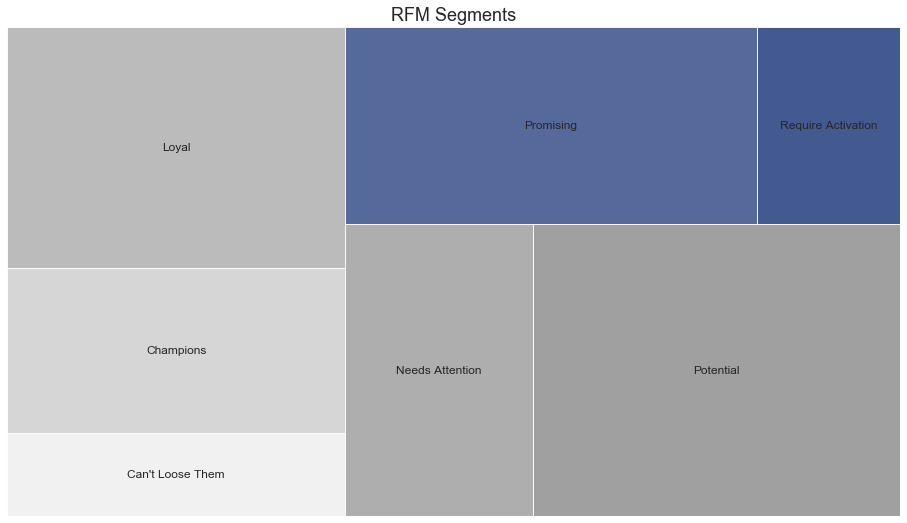

In [165]:
import squarify

rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Can\'t Loose Them',
                     'Champions',
                     'Loyal',
                     'Needs Attention',
                     'Potential', 
                     'Promising', 
                     'Require Activation'], alpha=.9,color=['#f0f0f0','#d2d2d2','#b4b4b4','#a5a5a5','#969696',
                                                            '#425a90','#2e4884'])
plt.title("RFM Segments",fontsize=18)
plt.axis('off')
plt.show()

In [ ]:
# Based on the RFM_Score_s all customers are categorised into 7 categories :

# 'Can\'t Loose Them' ====  RMF_Score_s  ≥  9
# 'Champions' ==== 8 ≤ RMF_Score_s < 9
# 'Loyal' ==== 7 ≤ RMF_Score_s <8
# 'Needs Attention' ==== 6 ≤ RMF_Score_s <7
# 'Potential' ==== 5 ≤ RMF_Score_s < 6
# 'Promising' ==== 4 ≤ RMF_Score_s < 5 
# 'Require Activation' RMF_Score_s <4